In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from geopy.distance import great_circle
import warnings
from joblib import dump, load

In [3]:
df2 = pd.read_pickle("/Users/liyannie/Desktop/Sp_2019_courses/DS_Indus/project/liyan/df2.pkl")

# 4. Feature engineering

## 4.1 Feature extraction
- haversine/manhattan dist
- day_of_week and hour_of_day
- weekday and work_hours
- center of lat and lon between pickup and dropoff
- kmeans clustering to cluster lat/lon into small neighborhoods
- num_rides in the pickup_cluster, center_cluster and dropoff_cluster on that hour of that day

### Haversine and Manhattan distance

In [4]:
def distance_gc(row):
    try:
        coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
        coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
        return great_circle(coords_1, coords_2).miles
    except:
        return None

In [5]:
def distance_manhattan(row):
    try:
        coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
        coords_2 = (row['pickup_latitude'], row['dropoff_longitude'])
        coords_3 = (row['dropoff_latitude'], row['dropoff_longitude'])
        return great_circle(coords_1, coords_2).miles + great_circle(coords_2, coords_3).miles
    except:
        return None

In [6]:
df2['haver_dist'] = df2.apply(distance_gc, axis=1)

In [8]:
df2['man_dist'] = df2.apply(distance_manhattan, axis=1)

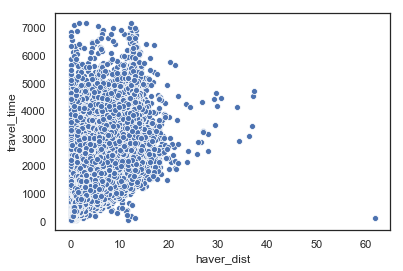

In [899]:
sns.scatterplot(x = df2['haver_dist'], y = df2['travel_time'])
plt.ylabel('travel_time')
plt.show()

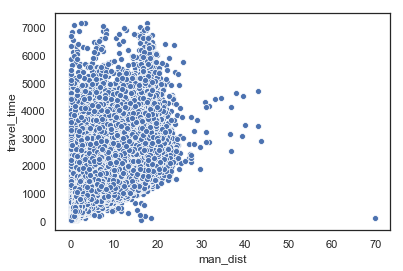

In [898]:
sns.scatterplot(x = df2['man_dist'], y = df2['travel_time'])
plt.ylabel('travel_time')
plt.show()

Get rid of outliers even further

In [9]:
df2 = df2.loc[df2['haver_dist'] < 25, :]

In [10]:
df2 = df2.loc[df2['man_dist'] < 30, :]

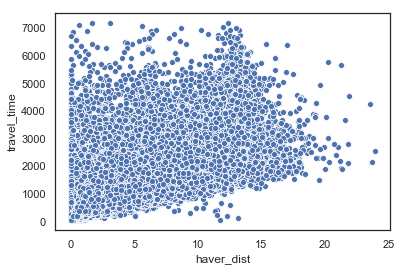

In [966]:
sns.scatterplot(x = df2['haver_dist'], y = df2['travel_time'])
plt.show()

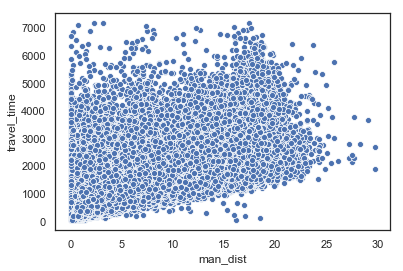

In [967]:
sns.scatterplot(x = df2['man_dist'], y = df2['travel_time'])
plt.show()

### day of week and hour_of_day


In [11]:
df2.loc[:, 'hour_of_day'] = df2['pickup_datetime'].dt.hour
df2.loc[:, 'day_of_week'] = df2['pickup_datetime'].dt.dayofweek

In [907]:
df2.shape

(741243, 24)

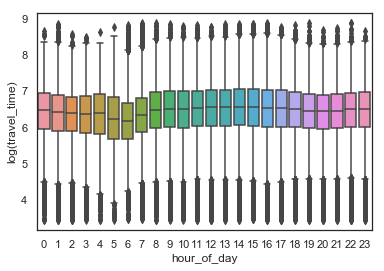

In [910]:
sns.boxplot(x = df2['hour_of_day'], y = np.log(df2['travel_time']))
plt.ylabel('log(travel_time)')
plt.show()

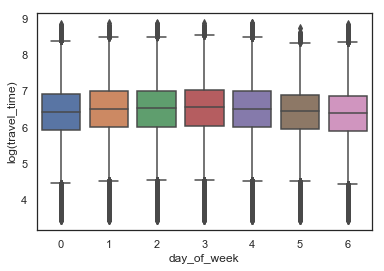

In [911]:
sns.boxplot(x = df2['day_of_week'], y = np.log(df2['travel_time']))
plt.ylabel('log(travel_time)')
plt.show()

### work (1 or 0) and weekday (1 or 0)

In [12]:
df2['work'] = np.where( (df2['hour_of_day'] > 7) & (df2['hour_of_day'] < 19), 1, 0)
df2['weekday'] = np.where( (df2['day_of_week'] != 5) & (df2['day_of_week'] != 6), 1, 0)

In [913]:
df2.shape

(741243, 26)

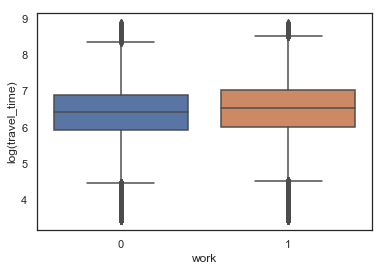

In [915]:
sns.boxplot(x = df2['work'], y = np.log(df2['travel_time']))
plt.ylabel('log(travel_time)')
plt.show()

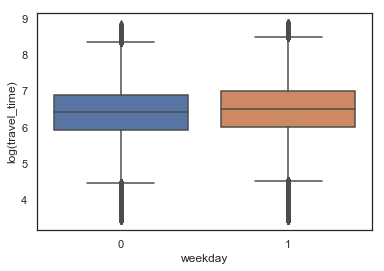

In [916]:
sns.boxplot(x = df2['weekday'], y = np.log(df2['travel_time']))
plt.ylabel('log(travel_time)')
plt.show()

### Center lat and lon between pickup and dropoff

In [13]:
df2.loc[:, 'center_latitude'] = (df2['pickup_latitude'].values + df2['dropoff_latitude'].values) / 2
df2.loc[:, 'center_longitude'] = (df2['pickup_longitude'].values + df2['dropoff_longitude'].values) / 2

In [918]:
df2.shape

(741243, 28)

### K-means Clustering (100): pickup, center and dropoff cluster

In [14]:
train = df2.loc[df2['date_of_year'] < '2016-05-25']
test = df2.loc[df2['date_of_year'] > '2016-05-25']

In [1012]:
#X_train = train.loc[:, train.columns != 'travel_time']
#y_train = train['travel_time']
#X_test = test.loc[:, train.columns != 'travel_time']
#y_test = test['travel_time']

In [15]:
# gather all coords in training set
train_coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                          train[['dropoff_latitude', 'dropoff_longitude']].values,
                          train[['pickup_latitude', 'pickup_longitude']].values,
                          train[['dropoff_latitude', 'dropoff_longitude']].values))

In [18]:
# randomly sample 500,000 of them to use for clustering

sample_ind = np.random.permutation(len(train_coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(train_coords[sample_ind])

In [21]:
# save trained model to joblib
dump(kmeans, 'kmeans.joblib')

['kmeans.joblib']

In [22]:
warnings.filterwarnings('ignore')

# predict train set clusters
pickup_coords_tr = train[['pickup_latitude', 'pickup_longitude']]
train['pickup_cluster'] = kmeans.predict(pickup_coords_tr)

dropoff_coords_tr = train[['dropoff_latitude', 'dropoff_longitude']]
train['dropoff_cluster'] = kmeans.predict(dropoff_coords_tr)

center_coords_tr = train[['center_latitude', 'center_longitude']]
train['center_cluster'] = kmeans.predict(center_coords_tr)

In [23]:
warnings.filterwarnings('ignore')

# predict test set clusters
pickup_coords_te = test[['pickup_latitude', 'pickup_longitude']]
test['pickup_cluster'] = kmeans.predict(pickup_coords_te)

dropoff_coords_te = test[['dropoff_latitude', 'dropoff_longitude']]
test['dropoff_cluster'] = kmeans.predict(dropoff_coords_te)

center_coords_te = test[['center_latitude', 'center_longitude']]
test['center_cluster'] = kmeans.predict(center_coords_te)

In [1030]:
test.columns

Index(['pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'travel_time', 'date_of_year', 'mo', 'da', 'temp', 'visib', 'wdsp',
       'gust', 'max', 'min', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets',
       'haver_dist', 'man_dist', 'hour_of_day', 'day_of_week', 'work',
       'weekday', 'center_latitude', 'center_longitude', 'pickup_cluster',
       'dropoff_cluster', 'center_cluster'],
      dtype='object')

In [1057]:
train.shape

(650098, 34)

### visualize clusters

In [4]:
train = pd.read_pickle("/Users/liyannie/Desktop/Sp_2019_courses/DS_Indus/project/liyan/train.pkl")

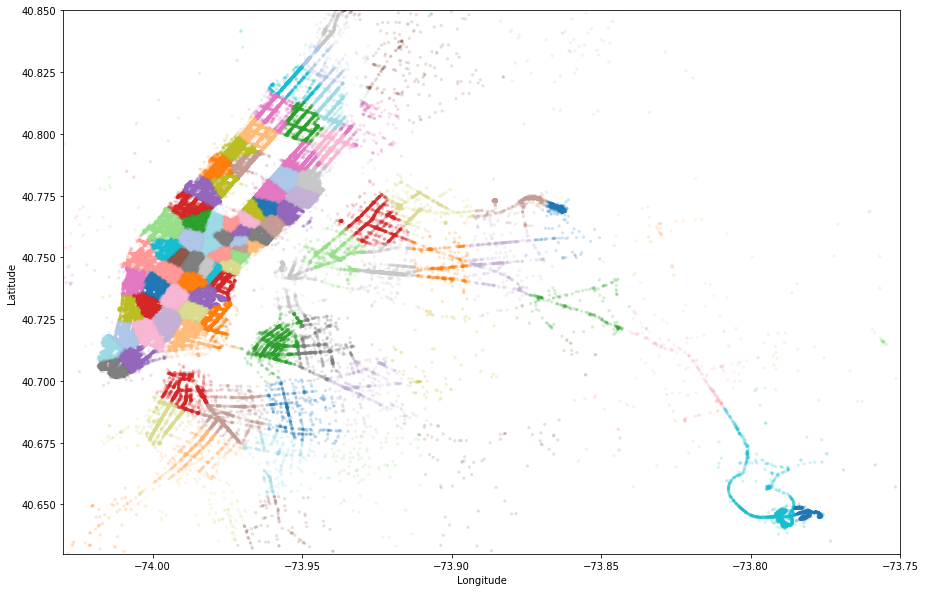

In [30]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 10))
ax.scatter(train.pickup_longitude.values[:640000], train.pickup_latitude.values[:640000], s=10, lw=0,
           c=train.pickup_cluster[:640000].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Avg num of rides in each 3 clusters, for that week day, at that hour. 

In [24]:
def num_rides(df):
    
    num_rides_pcluster = df.groupby(['pickup_cluster', 'day_of_week', 'hour_of_day']).count()[['pickup_latitude']].rename(columns={'pickup_latitude':'num_rides_pcluster'})
    num_rides_pcluster['num_rides_pcluster'] = num_rides_pcluster['num_rides_pcluster'].apply(lambda x: x/19)
    df = pd.merge(df, num_rides_pcluster, on=['pickup_cluster','day_of_week', 'hour_of_day'])

    num_rides_dcluster = df.groupby(['dropoff_cluster', 'day_of_week', 'hour_of_day']).count()[['dropoff_latitude']].rename(columns={'dropoff_latitude':'num_rides_dcluster'})
    num_rides_dcluster['num_rides_dcluster'] = num_rides_dcluster['num_rides_dcluster'].apply(lambda x: x/19)
    df = pd.merge(df, num_rides_dcluster, on=['dropoff_cluster','day_of_week', 'hour_of_day'])

    num_rides_ccluster = df.groupby(['center_cluster', 'day_of_week', 'hour_of_day']).count()[['center_latitude']].rename(columns={'center_latitude':'num_rides_ccluster'})
    num_rides_ccluster['num_rides_ccluster'] = num_rides_ccluster['num_rides_ccluster'].apply(lambda x: x/19)
    df = pd.merge(df, num_rides_ccluster, on=['center_cluster','day_of_week', 'hour_of_day'])
    
    return df

In [25]:
train = num_rides(train)
test = num_rides(test)

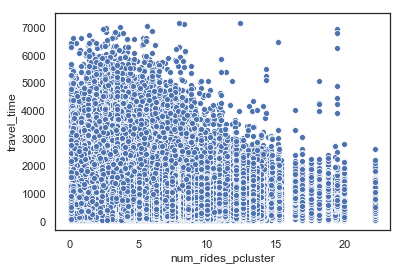

In [1047]:
sns.scatterplot(x = train['num_rides_pcluster'], y = train['travel_time'])
plt.show()

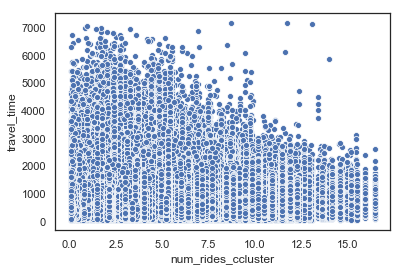

In [1048]:
sns.scatterplot(x = train['num_rides_ccluster'], y = train['travel_time'])
plt.show()

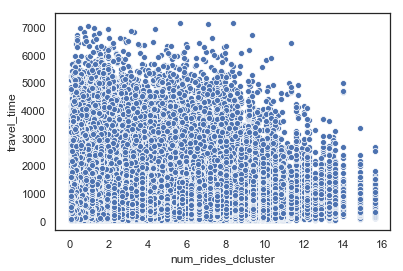

In [1049]:
sns.scatterplot(x = train['num_rides_dcluster'], y = train['travel_time'])
plt.show()

### Correlation
Numerical: passenger_count, mo, da, temp, visib, wdsp, gust, max, min, prcp, hour_of_day, day_of_week, haver_dist,
mean_dist, mean_hav, mean_man

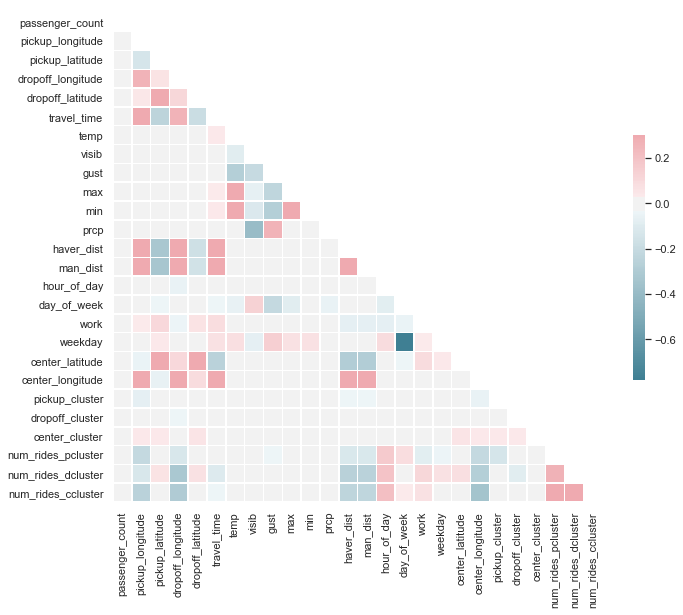

In [1050]:
sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### remove columns that will not be used for training models

In [1052]:
train.columns

Index(['pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'travel_time', 'date_of_year', 'mo', 'da', 'temp', 'visib', 'wdsp',
       'gust', 'max', 'min', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets',
       'haver_dist', 'man_dist', 'hour_of_day', 'day_of_week', 'work',
       'weekday', 'center_latitude', 'center_longitude', 'pickup_cluster',
       'dropoff_cluster', 'center_cluster', 'num_rides_pcluster',
       'num_rides_dcluster', 'num_rides_ccluster'],
      dtype='object')

In [26]:
train3 = train.drop(labels = ['pickup_datetime', 'date_of_year', 'da', 
                              'center_latitude', 'center_longitude', 
                              'center_cluster'], 
                    axis = 1)

test3 = test.drop(labels = ['pickup_datetime', 'date_of_year', 'da', 
                              'center_latitude', 'center_longitude', 
                              'center_cluster'], 
                    axis = 1)

In [27]:
train3.to_pickle("/Users/liyannie/Desktop/Sp_2019_courses/DS_Indus/project/liyan/train.pkl")
test3.to_pickle("/Users/liyannie/Desktop/Sp_2019_courses/DS_Indus/project/liyan/test.pkl")